In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({
    'font.family': 'serif',  # or 'sans-serif'
    'font.size': 10,         # base font size
    'axes.labelsize': 10,    # axis label size
    'axes.titlesize': 12,    # title size
    'xtick.labelsize': 8,    # x-axis tick label size
    'ytick.labelsize': 8,    # y-axis tick label size
    'legend.fontsize': 8,    # legend font size
})

DATASET_COLORS = {
    "trivia_qa_2_60k": "#000000",    # black
    "cities_10k": "#e41a1c",         # red
    "gsm8k": "#4daf4a",              # green
    "math_operations_6k": "#377eb8",  # darker yellow (gold)
    "medals_9k": "#ff7f00",          # orange
    "birth_years_4k": "#984ea3",     # purple
    "notable_people": "#a65628",     # brown
}
DATASET_MARKERS = {
    "trivia_qa_2_60k": "o",    # circle
    "cities_10k": "s",          # square
    "gsm8k": "D",              # diamond
    "math_operations_6k": "^",  # triangle up
    "medals_9k": "X",          # uppercase X for thicker x
    "birth_years_4k": "P",      # uppercase P for thicker plus
    "notable_people": "v",      # triangle down
}

mistral_7b_parquet = "best_layer_finding/mistral_7b_instruct/classification_data/directions_2.parquet"
mistral_8b_parquet = "best_layer_finding/ministral_8b_instruct/classification_data/directions_2.parquet"
qwen_2_5_parquet = "best_layer_finding/qwen_2.5_7b_instruct/classification_data/directions_2.parquet"
llama3_1_parquet = "best_layer_finding/llama3.1_8b_chat/classification_data/directions_2.parquet"
llama3_3_parquet = "best_layer_finding/llama3.3_70b/classification_data/directions_2.parquet"
deepseek_qwen_32b_parquet = "best_layer_finding/deepseek_qwen_32b/classification_data/directions_2.parquet"

best_layer_mistral = 16
best_layer_ministral = 18
best_layer_qwen_2_5 = 22
best_layer_llama3_1 = 14
best_layer_llama3_3 = 76
best_layer_deepseek_qwen_32b = 44


LAYER_COUNTS = dict(
    qwen_2_7b_n_layers = 28,
    qwen_32b_n_layers = 64,
    llama3_8b_n_layers = 32,
    llama3_70b_n_layers = 80,
    mistral_8b_n_layers = 36, # ministral
    mistral_7b_n_layers = 32
)

DATASET_NAME_MAP = {
    "trivia_qa_2_60k": "TriviaQA",
    "cities_10k": "Cities",
    "gsm8k": "GSM8k",
    "math_operations_6k": "Math Operations",
    "medals_9k": "Medals",
    "birth_years_4k": "Birth Years",
    "notable_people": "Notable People"
}

In [8]:
def clean_dataset(df):
    df["prompt_id_train"] = df["prompt_id_train"].str.replace("base_3_shot", "base")
    # df["prompt_id_test"] = df["prompt_id_test"].str.replace("base_3_shot", "base")
    df = df[df["prompt_id_train"] == "base"]
    # df = df[df["prompt_id_test"] == "base"]
    df = df[df["dataset_id_train"] != "birth_years_4k"]
    return df

mistral_7b_df = clean_dataset(pd.read_parquet(mistral_7b_parquet))
mistral_8b_df = clean_dataset(pd.read_parquet(mistral_8b_parquet))
qwen_2_5_df = clean_dataset(pd.read_parquet(qwen_2_5_parquet))
llama3_1_df = clean_dataset(pd.read_parquet(llama3_1_parquet))
llama3_3_df = clean_dataset(pd.read_parquet(llama3_3_parquet))
deepseek_qwen_32b_df = clean_dataset(pd.read_parquet(deepseek_qwen_32b_parquet))


In [9]:
from scipy.spatial.distance import cosine

def cosine_similarity_distribution(dir1, dir2):
    dir1 = np.array(dir1)
    dir2 = np.array(dir2)
    return 1 - cosine(dir1, dir2)

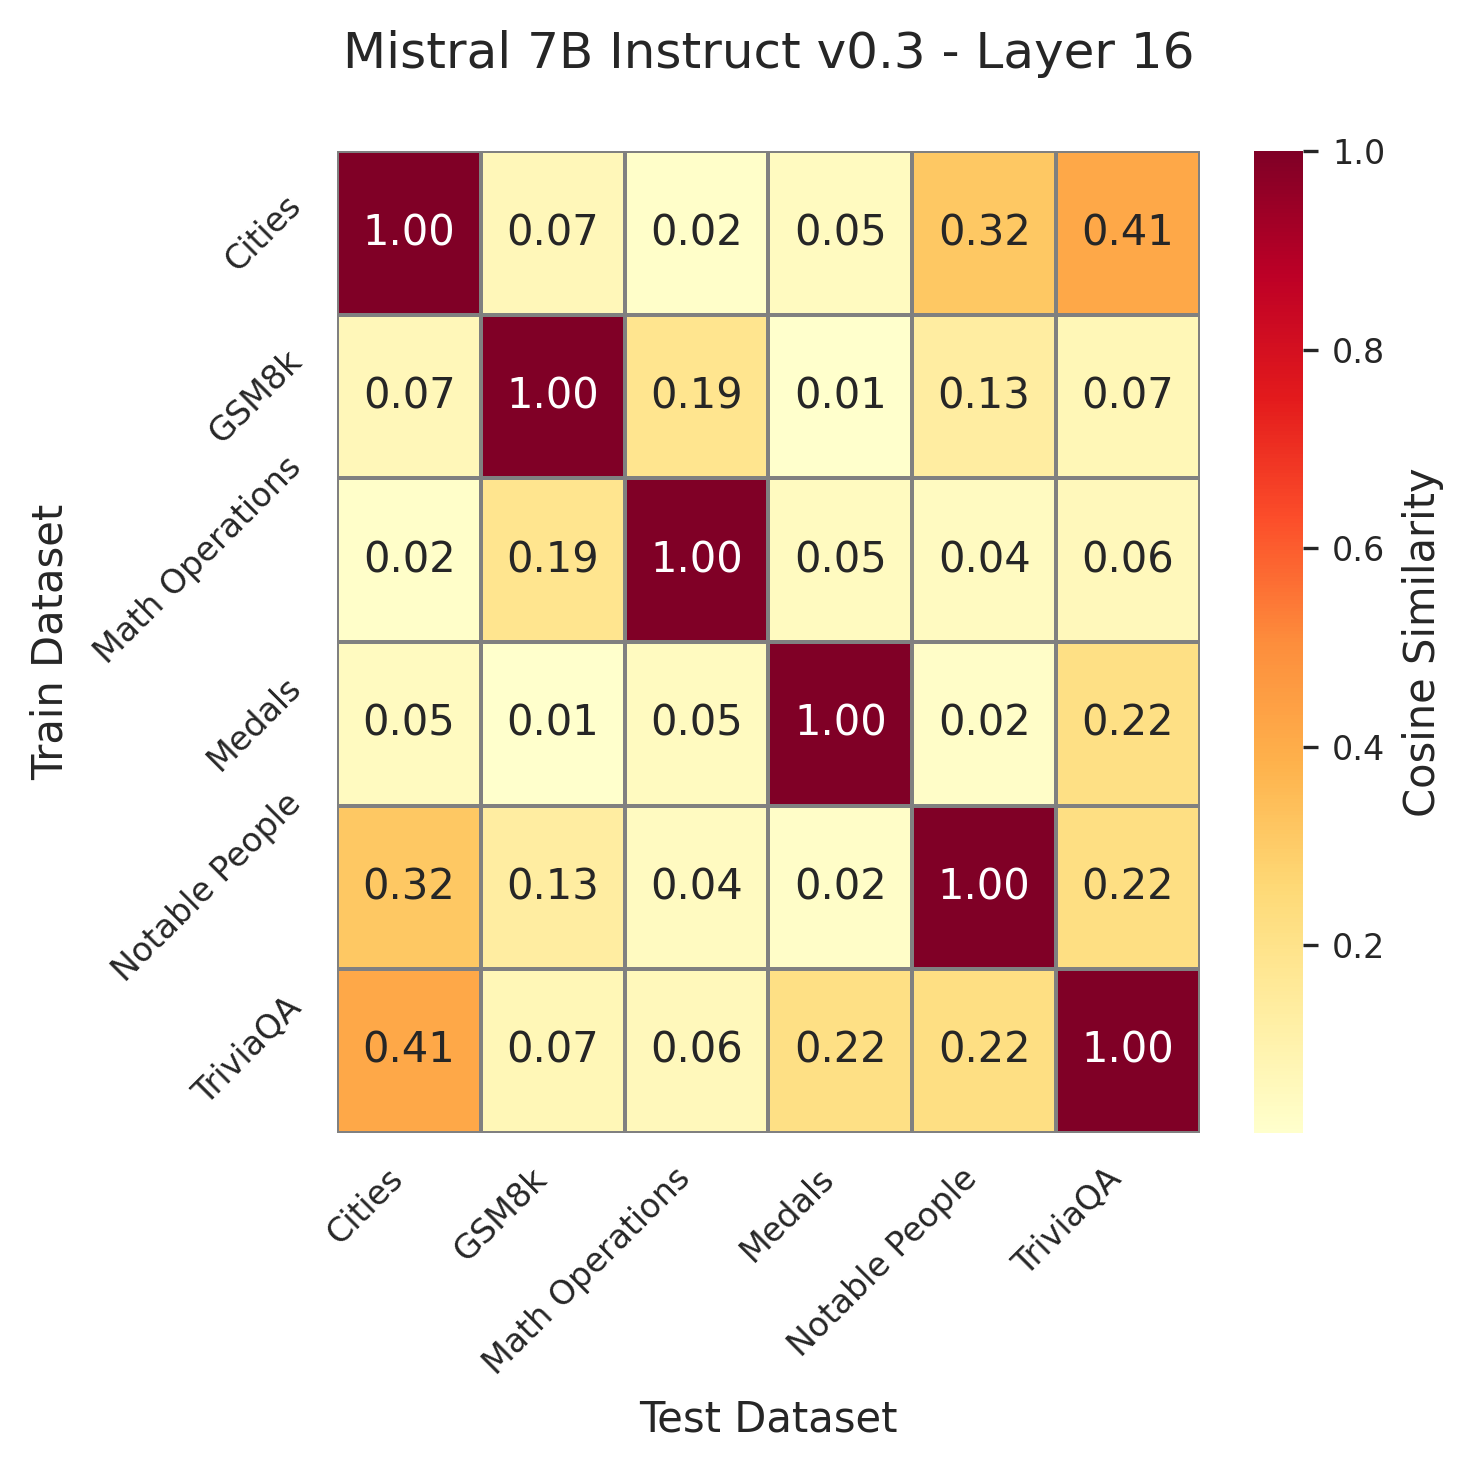

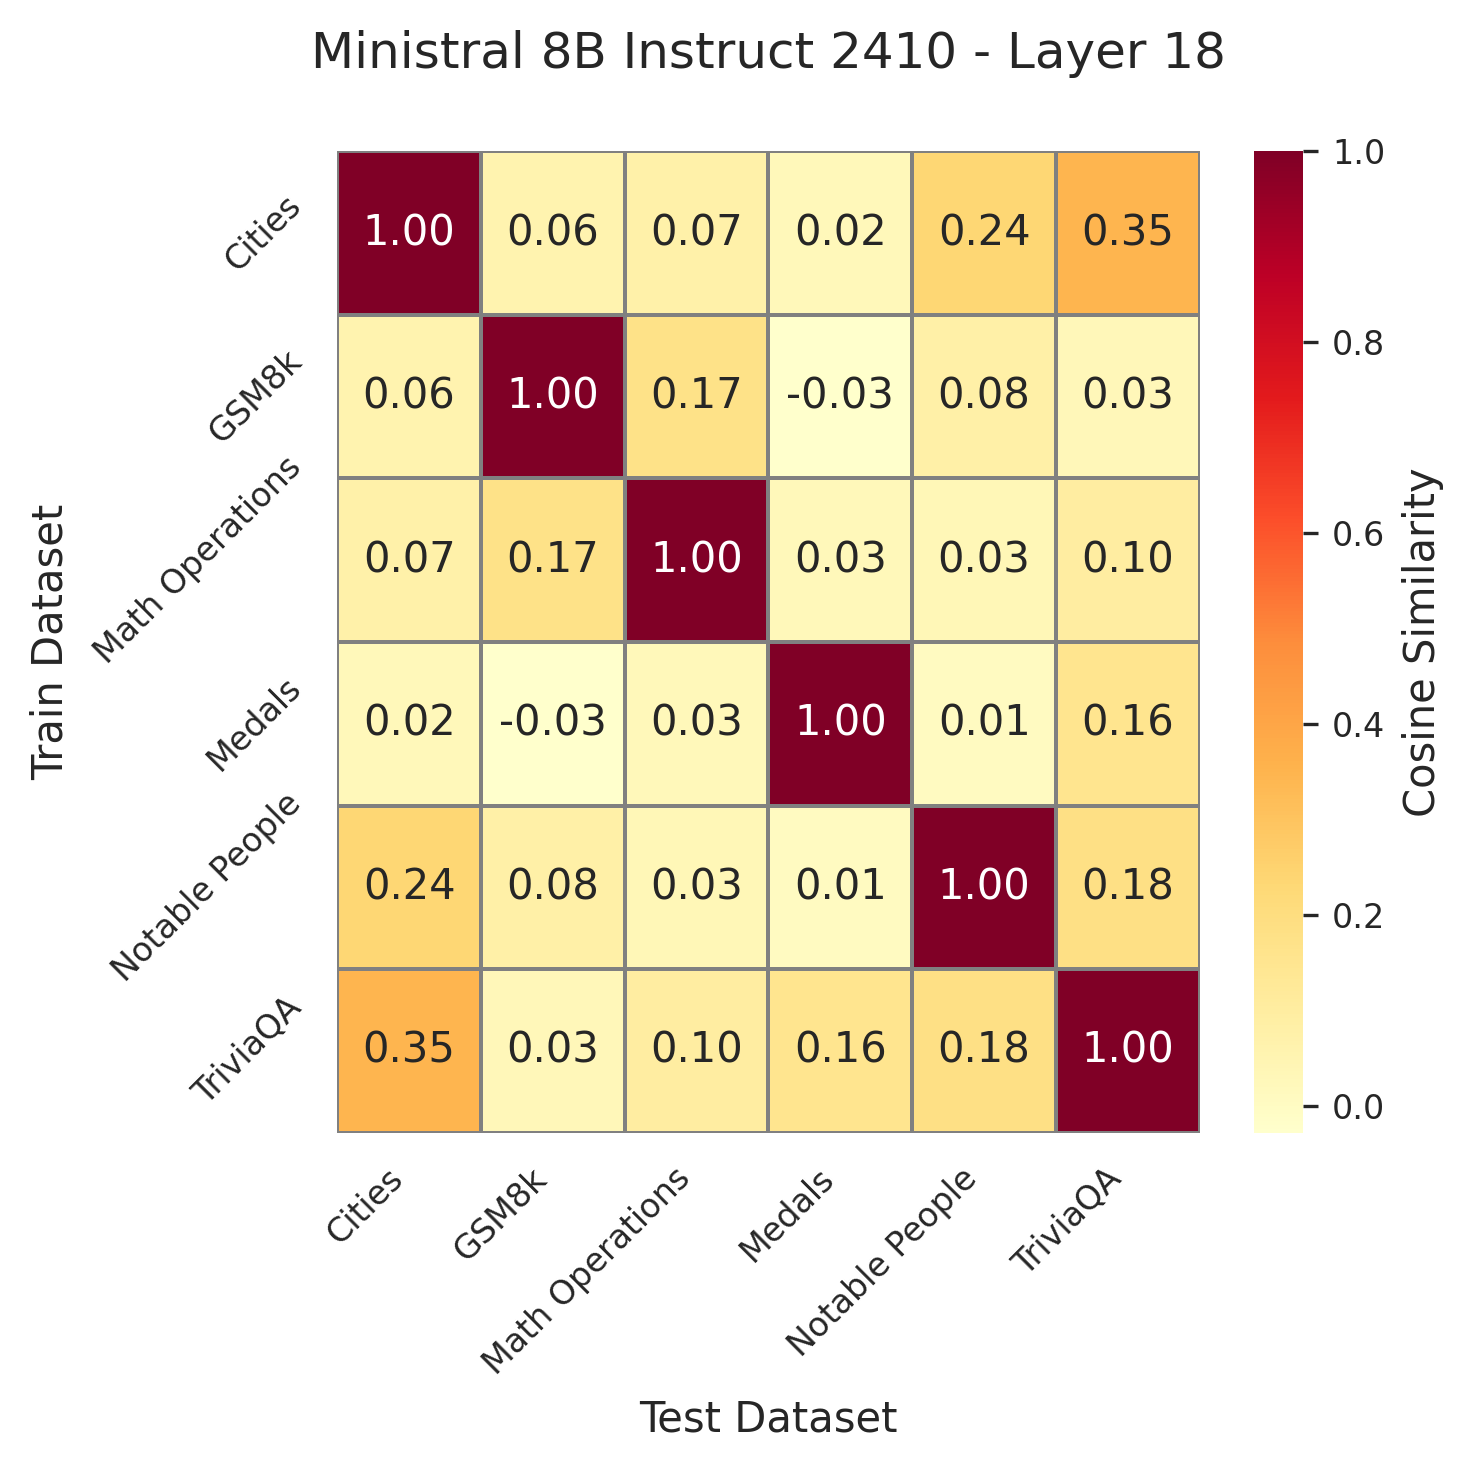

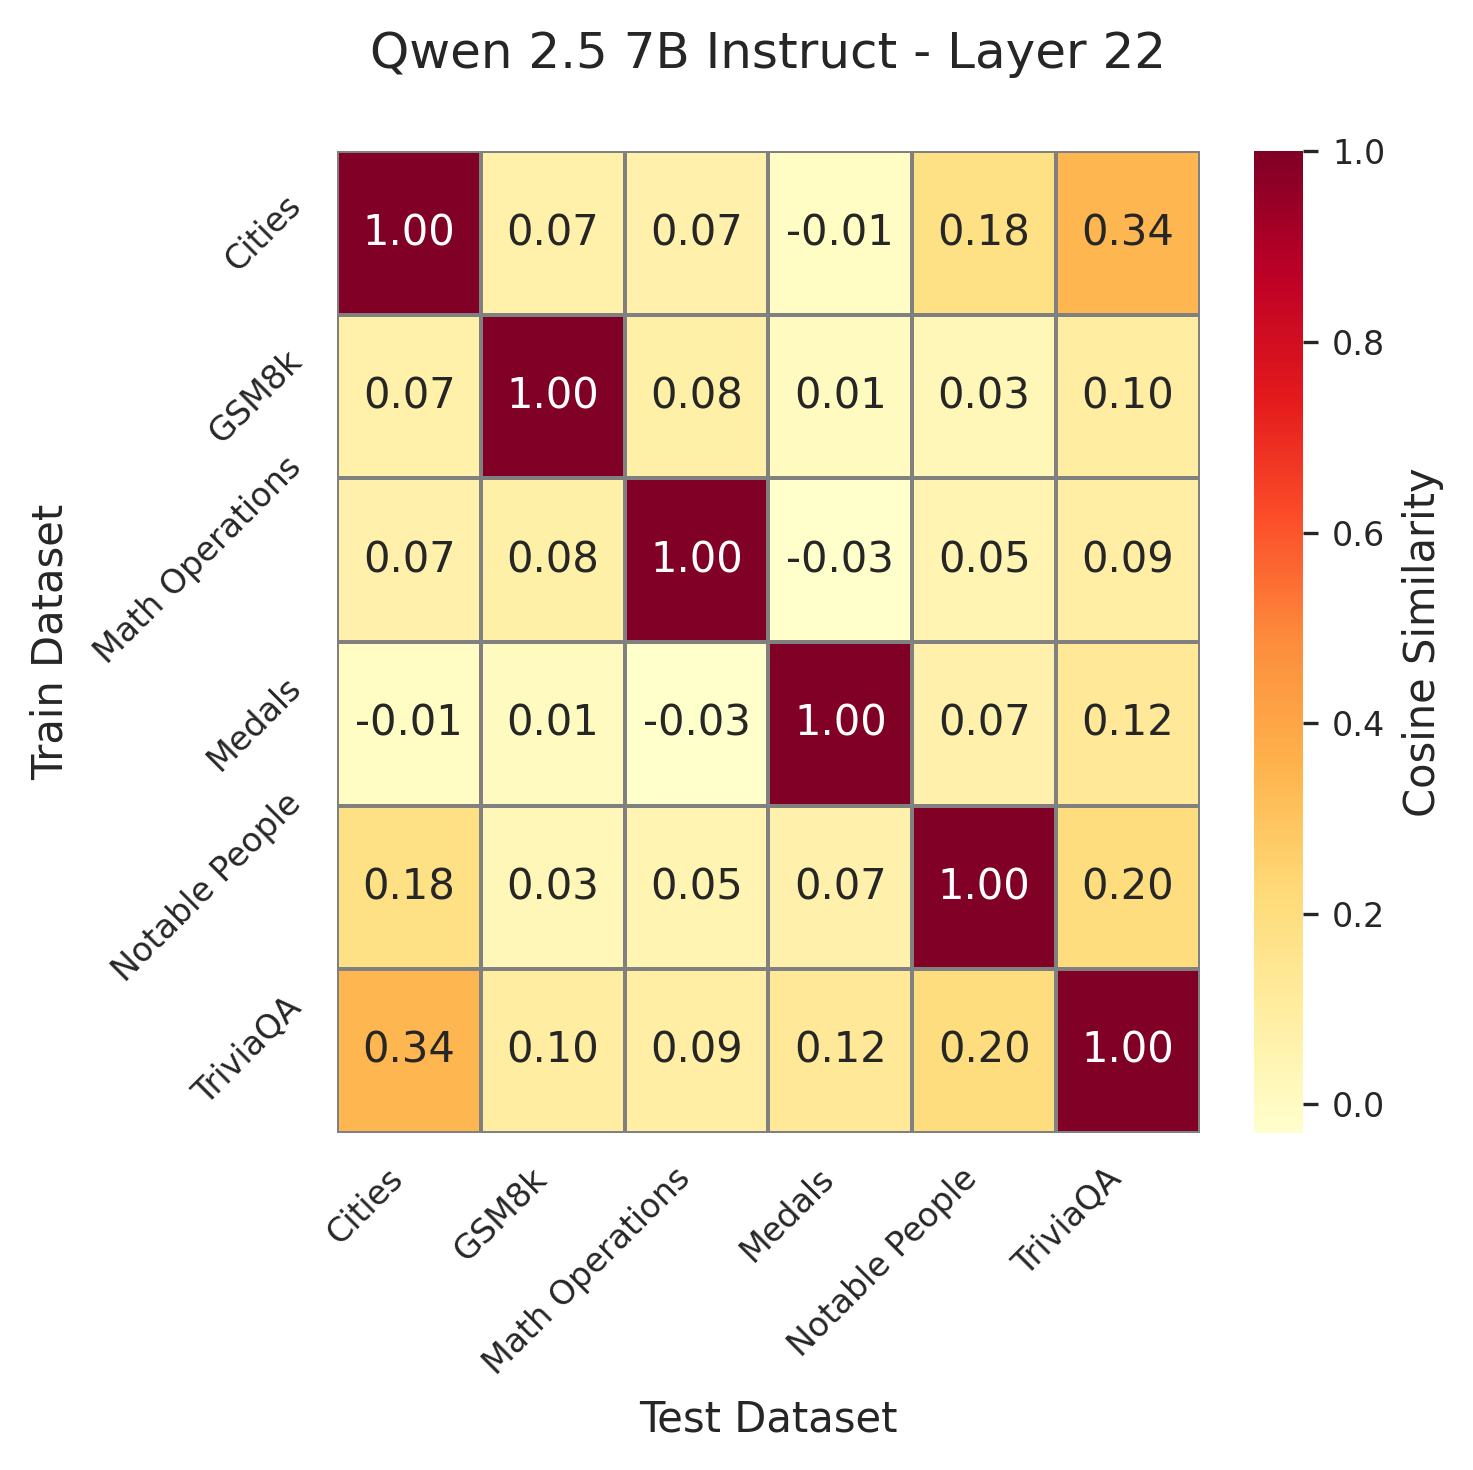

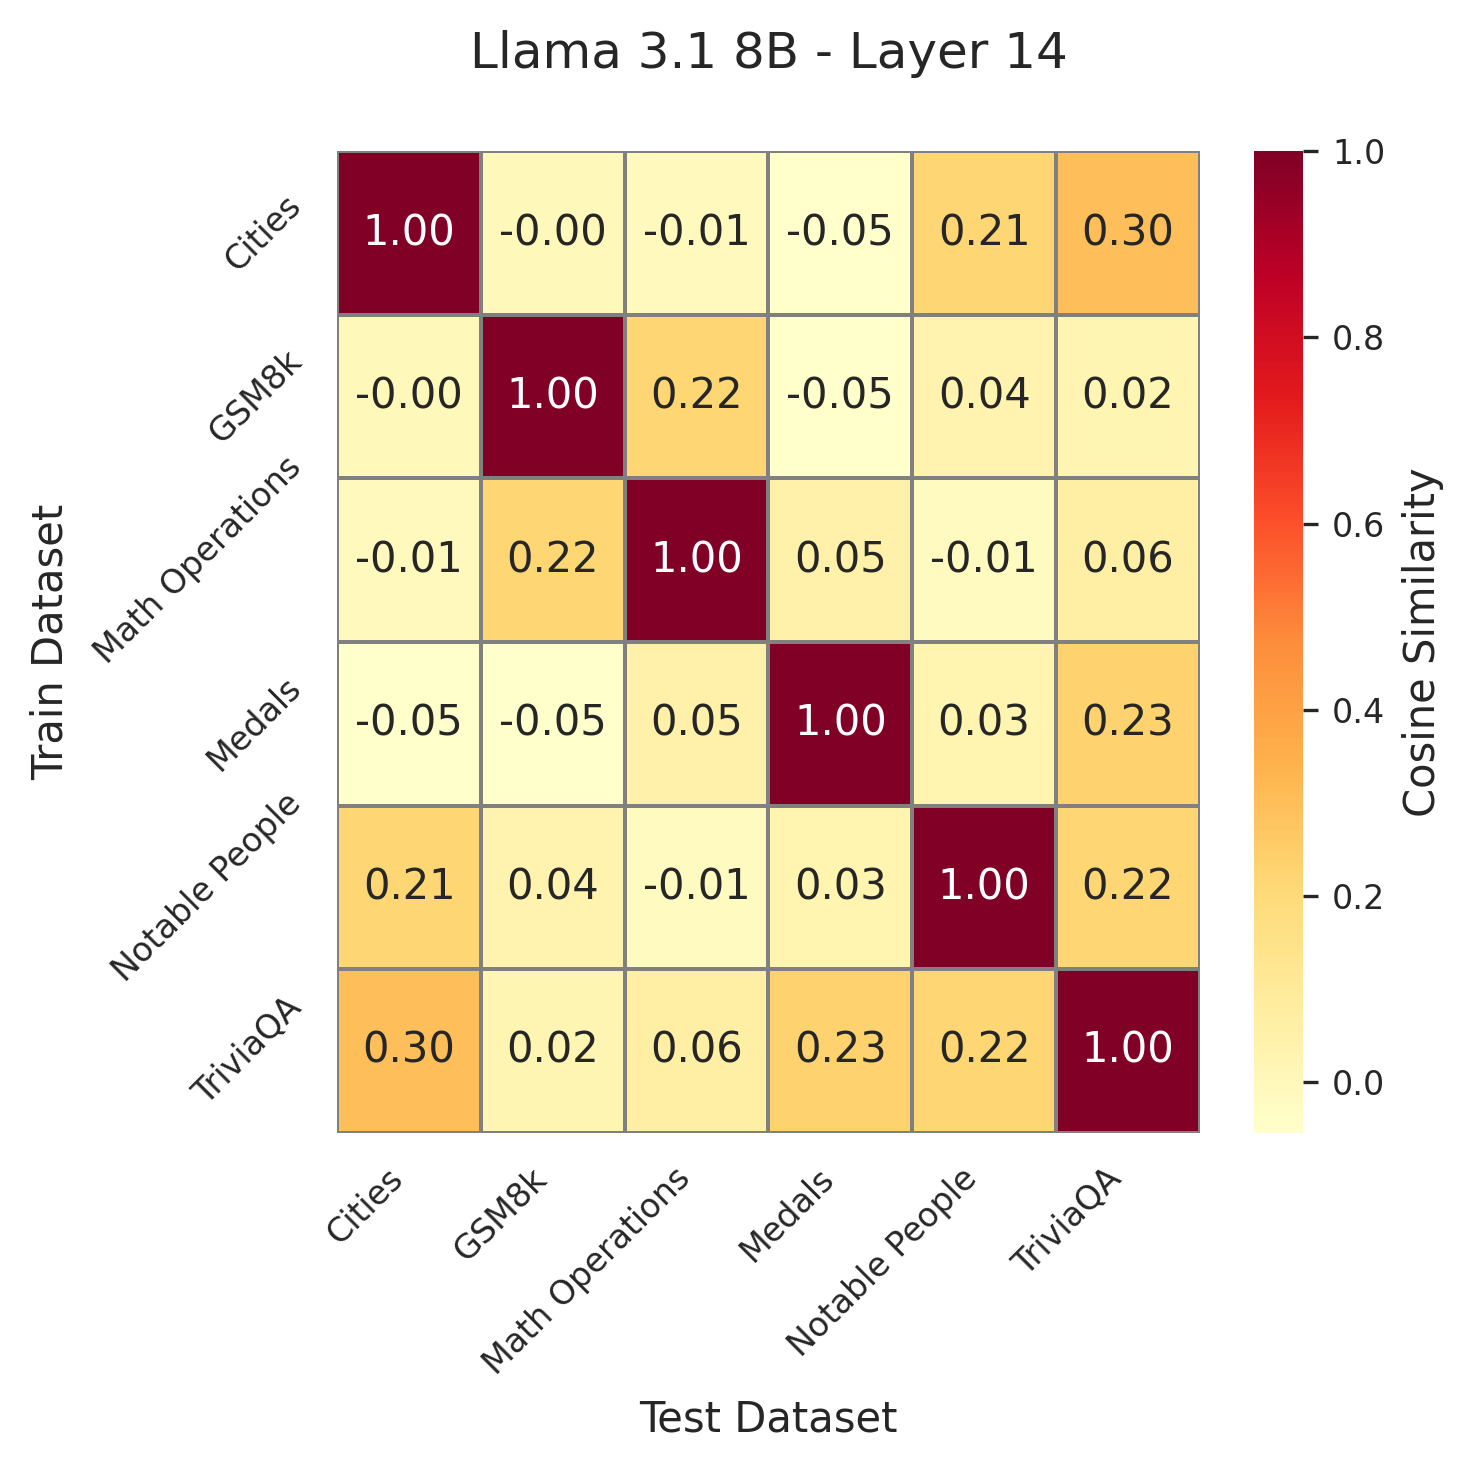

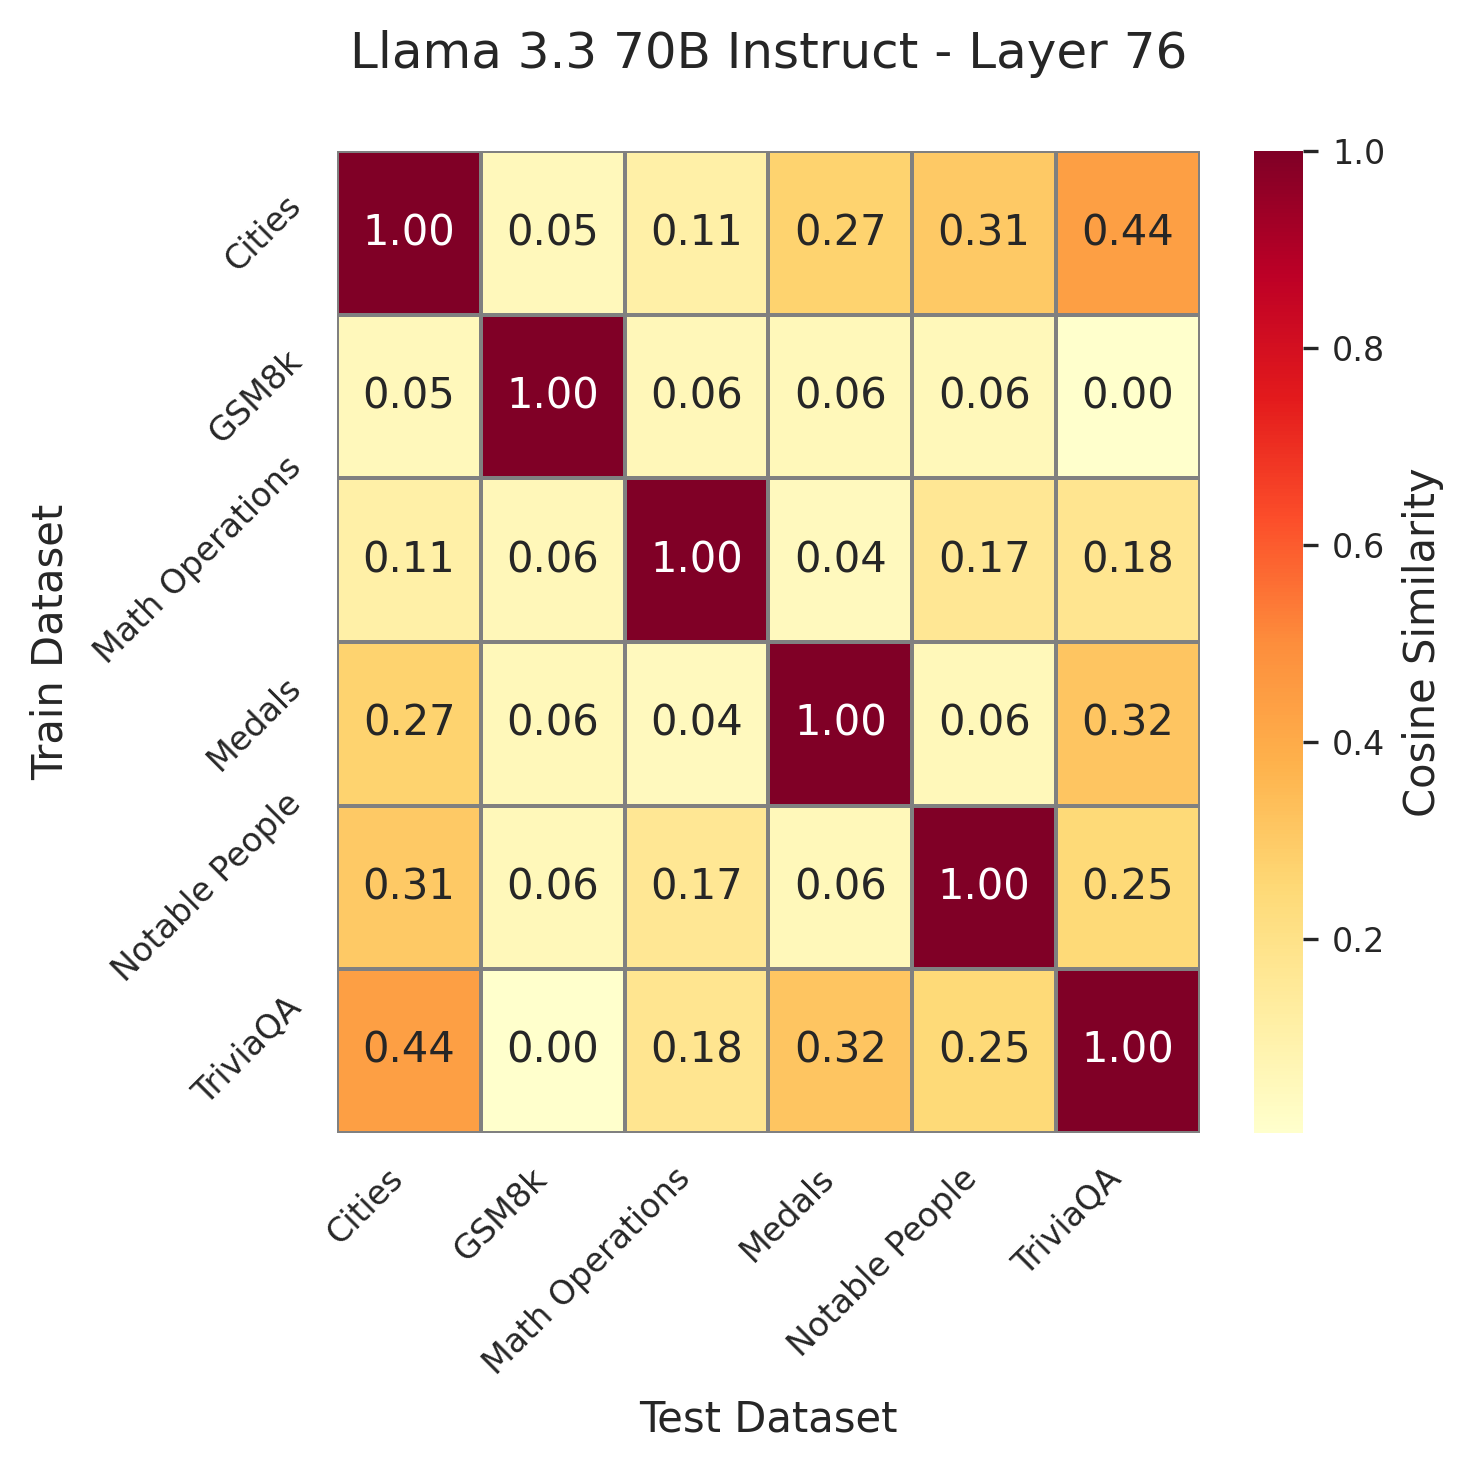

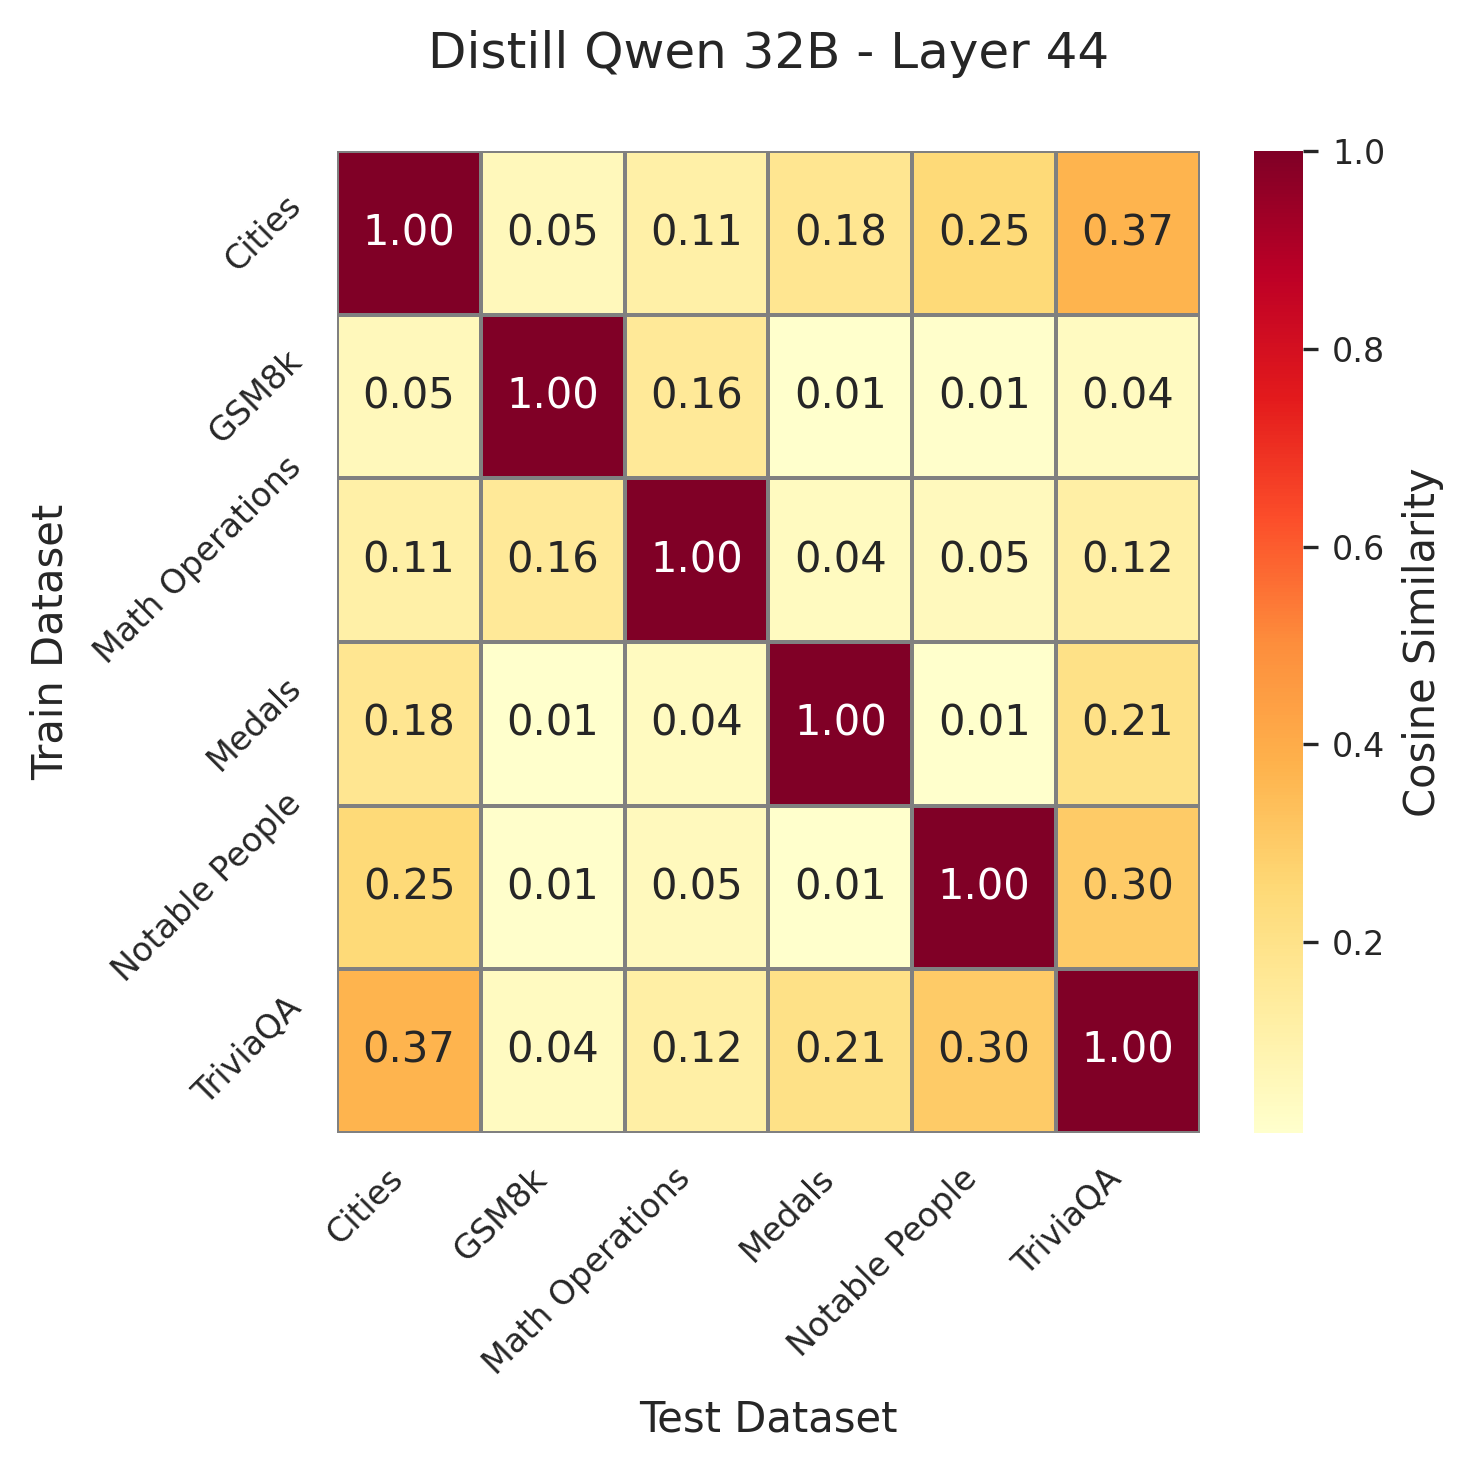

In [11]:
def heatmap_cosine_similarities_across_train_test_and_dataset_combinations(model_stats_dict, figsize=(6, 4), save_path=None):
    assert len(model_stats_dict) == 1, "Only one model is supported"
    model_name, model_dict = list(model_stats_dict.items())[0]
    dir_df = model_dict["dir_df"].copy()

    layer = model_dict["layer"]
    dir_df = dir_df[dir_df['layer'] == layer]

    heatmap_df = pd.DataFrame()
    for i, row_i in dir_df.iterrows():
        for j, row_j in dir_df.iterrows():
            heatmap_df.loc[
                DATASET_NAME_MAP[row_i["dataset_id_train"]],
                DATASET_NAME_MAP[row_j["dataset_id_train"]]
            ] = cosine_similarity_distribution(row_i["direction"], row_j["direction"])

    # heatmap_df = averaged.pivot(
    #     index="dataset_id_train",
    #     columns="dataset_id_test",
    #     values="cosine_similarities",
    # )
    # ax = sns.heatmap(data=heatmap_df, annot=True)
    # ax.set_xlabel("Test Dataset")
    # ax.set_ylabel("Train Dataset")
    # ax.set_title(f"{model_name} - Layer {layer}\nTest ROC AUCs")
    # plt.tight_layout()
    # plt.show()

    plt.figure(figsize=figsize, dpi=300)
    sns.set_style("whitegrid")
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Cosine Similarity'},
        linewidths=0.5,
        linecolor='gray'
    )
    # plt.gca().collections[0].set_clim(0.0, 1.0)  # Set colorbar range from 0.0 to 1.0
    plt.title(f'{model_name} - Layer {layer}', pad=20)
    # plt.xlabel('Test Dataset')
    # plt.ylabel('Train Dataset')
    plt.yticks(rotation=45, ha='right')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Test Dataset')
    plt.ylabel('Train Dataset')
    plt.tight_layout()
    if save_path:
        plt.savefig(
            save_path, 
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=300
        )
    plt.show()

for model_name, model_dict in {
    "Mistral 7B Instruct v0.3": {"dir_df": mistral_7b_df, "layer": best_layer_mistral},
    "Ministral 8B Instruct 2410": {"dir_df": mistral_8b_df, "layer": best_layer_ministral},
    "Qwen 2.5 7B Instruct": {"dir_df": qwen_2_5_df, "layer": best_layer_qwen_2_5},
    "Llama 3.1 8B": {"dir_df": llama3_1_df, "layer": best_layer_llama3_1},
    "Llama 3.3 70B Instruct": {"dir_df": llama3_3_df, "layer": best_layer_llama3_3},
    "Distill Qwen 32B": {"dir_df": deepseek_qwen_32b_df, "layer": best_layer_deepseek_qwen_32b}
}.items():
    heatmap_cosine_similarities_across_train_test_and_dataset_combinations(
        {
            model_name: model_dict
        },
        figsize=(5, 5),
        save_path=f"plotting_for_article/cosine_similarities_best_layer_{model_name}.pdf"
    )